#### Importing the required libraries

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
import joblib
%matplotlib inline

### 1). Data Extraction

In [2]:
filename = r'Data\TestData.csv'
df = pd.read_csv(filename, parse_dates=['date_of_application'], encoding='latin-1')
df.head()

,date_of_application,date_of_birth,loan_financed_amount,assessment_outcome,time_as_customer,age_asset,residential_type,years_at_residence,number_of_credit_cards,occupation,occupation_type,occupation_years,previous_defaults,score,loan_performance
0,2014-12-22,NaN,5349.0,Approved,130.0,New,NaN,NaN,0.0,NaN,NaN,NaN,0,519,GOOD
1,2014-11-12,NaN,23350.0,Approved,28.0,New,NaN,NaN,0.0,NaN,NaN,NaN,0,650,GOOD
2,2015-09-01,NaN,10497.0,Approved,27.0,New,NaN,NaN,0.0,NaN,NaN,NaN,0,648,GOOD
3,2014-05-12,18-Jul-48,2920.0,NaN,NaN,New,RENT,LESS THAN 1 YEAR,NaN,RETIRED,RETIRED,MORE THAN 4 YEARS,0,715,NaN
4,2014-09-12,22-Jan-70,19466.0,Approved,41.0,New,NaN,NaN,1.0,NaN,NaN,NaN,0,717,GOOD


### 2). Exploratory Data Analysis

In [6]:
# exploratory data analysis with pandas profile report
profile = ProfileReport(df, title = 'Loan Data Profile Report', explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
# saving the profile report to an html file for me to have a better look at
# profile.to_file('Loan_Data_Profile.html')

As seen in the Alerts section of the Profile Report Overview, years_at_residence is highly correlated with both occupation_years and residential_type. Hence, dropping both occupation_years and residential_type and keeping years_at_residence to get rid of multi-collinearity.

One noticeable characteristic of this data set is that for nearly 30% of entries, the label or the target variable is missing. According to the Missing Values section in the Profile Report, missing values of loan_performance is strongly associated with the missing values of assessment_outcome. In the next step, I am planning to explore more on the relationship between these two entries.

In [3]:
# Separating the entries with missing loan performance
missing_target_data = df.loc[df['loan_performance'].isnull()]
print(missing_target_data.shape)
missing_target_data.head()

(1113, 15)


,date_of_application,date_of_birth,loan_financed_amount,assessment_outcome,time_as_customer,age_asset,residential_type,years_at_residence,number_of_credit_cards,occupation,occupation_type,occupation_years,previous_defaults,score,loan_performance
3,2014-05-12,18-Jul-48,2920.0,NaN,NaN,New,RENT,LESS THAN 1 YEAR,NaN,RETIRED,RETIRED,MORE THAN 4 YEARS,0,715,NaN
5,2014-05-12,5-Jan-68,25350.0,NaN,NaN,8+,OWN YOUR OWN HOME,1 - 3 YEARS,NaN,ADVISOR,FULL TIME,MORE THAN 4 YEARS,0,777,NaN
6,2014-05-12,13-Dec-79,18850.0,NaN,NaN,New,OWN YOUR OWN HOME,1 - 3 YEARS,NaN,TECHNICIAN,FULL TIME,6 MONTHS - 2 YEARS,0,682,NaN
8,2014-07-12,13-Nov-67,29240.0,NaN,NaN,New,OWN YOUR OWN HOME,MORE THAN 5 YEARS,NaN,TICKET INSPECTOR,FULL TIME,MORE THAN 4 YEARS,1,523,NaN
9,2014-08-12,28-Aug-70,35750.0,NaN,NaN,New,RENT,1 - 3 YEARS,NaN,LABOURER,FULL TIME,2 YEARS - 4 YEARS,0,576,NaN


In [4]:
missing_target_data['assessment_outcome'].value_counts()

Approved    17
Declined     2
Name: assessment_outcome, dtype: int64

In [5]:
years = missing_target_data['date_of_application'].dt.year
years.value_counts().sort_index()

2014     26
2015    415
2016    645
2017     27
Name: date_of_application, dtype: int64

In the above cell, I analysed the year of application for the loans with missing loan_performance label, with the intention of confirming whether they all are recently applied/ granted loans, in which case, the financial institution may not have enough data/ transactions or evidence to measure the loan_performance. However, the analysis shows that these loans are distributed throughout 2014-2017 period, indicating that there isn’t strong evidence to support this assumption.

Out of 1113 entries with missing target label, 17 loans have been approved, 2 loans have been declined and the rest of 1094 entries have missing assessment outcomes. Based on that, we can assume that the bulk of these entries are the loans that are submitted for approval and later withdrawn or recalled.

### 3). Outcome Definition

#### A note on missing data in the loan_performance column
The target variable has 28% missing values, and there are several ways to address this including,
1). Consider them as a 3rd category such as 'Unknown', which would transform this into a multi-class classification problem.
2). Use a Clustering method or KNN imputation to predict the appropriate label 'Good' or 'Bad' and then incorporate those labels in to a binary classification model.
3). Based on the analysis above, assuming that the missing labels belong to rejected/ withdrawn loan applications, train and validate the model only on the data with target labels present.

 I am choosing the 3rd approach to move forward at this time. With that, this exercise could be defined as:
 Building, training and validating a binary classifier model, which would predict whether the loan_performance of a given loan is Good or Bad, based on the provided independent variables, using the labeled portion of the given dataset.

In [60]:
# Check for missing values
df.isnull().sum()

date_of_application          0
date_of_birth              396
loan_financed_amount         0
assessment_outcome        1236
time_as_customer           755
age_asset                    0
residential_type          1231
years_at_residence        1236
number_of_credit_cards     755
occupation                1190
occupation_type           1175
occupation_years          1291
previous_defaults            0
score                        0
loan_performance          1113
dtype: int64

In [62]:
df.dtypes

date_of_application       datetime64[ns]
date_of_birth                     object
loan_financed_amount             float64
assessment_outcome                object
time_as_customer                 float64
age_asset                         object
residential_type                  object
years_at_residence                object
number_of_credit_cards           float64
occupation                        object
occupation_type                   object
occupation_years                  object
previous_defaults                  int64
score                              int64
loan_performance                  object
dtype: object

### 4). Preprocessing

In [6]:
# retain the entries with loan performance label for model building
df = df.loc[df['loan_performance'].notnull()]
df.shape

(2810, 15)

In [7]:
# Performing train_test_split before applying any transformations, so that it prevent leaking training data in to the test data
X = df.drop(columns=['loan_performance'])
y = df['loan_performance']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

#### Up-sampling to handle the imbalances

In [8]:
# the dataset is highly imbalanced, hence up-sampling is needed.
pd.DataFrame(y_train).value_counts()

1    2024
0      83
dtype: int64

In [9]:
over_sampler = RandomOverSampler(sampling_strategy='auto')
X_train_rs, y_train_rs = over_sampler.fit_resample(X_train, y_train)

In [10]:
pd.DataFrame(y_train_rs).value_counts()

0    2024
1    2024
dtype: int64

### 5). Building the transformation pipelines

In [11]:
# defining the features to drop, categorical_features and numerical_features
drop_features = ['date_of_birth', 'date_of_application', 'occupation_years', 'residential_type', 'occupation']
numeric_features = ['loan_financed_amount', 'time_as_customer', 'number_of_credit_cards', 'previous_defaults', 'score' ]
categorical_features = ['assessment_outcome', 'age_asset', 'years_at_residence', 'occupation_type']

categorical_transformer = Pipeline(steps=[
    ('unknownimputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehotenc', OneHotEncoder(handle_unknown='ignore'))
])
numeric_transformer = Pipeline(steps=[
    ('meanimputer', SimpleImputer(strategy='mean')),
    ('stdscaler', StandardScaler())
])

column_transformer = ColumnTransformer(transformers=[('drop_columns', 'drop', drop_features),
                                                     ('numeric_processing', numeric_transformer, numeric_features),
                                                     ('categorical_processing', categorical_transformer, categorical_features)
                                                     ], remainder='drop')

In [19]:
clf_LR = LogisticRegression(solver='liblinear', random_state=10)
clf_RF = RandomForestClassifier(random_state=10)
clf_XGB = XGBClassifier(use_label_encoder=False, verbosity = 0, eval_metric = 'logloss')
clf_GBM = GradientBoostingClassifier()

In [15]:
pipe = Pipeline([('preprocessor', column_transformer), ('classifier', clf_LR)])

In [16]:
params_LR ={
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.1, 1, 10],
    'classifier': [clf_LR]
}
params_RF = {
    'classifier__n_estimators' :[100, 200, 300],
    'classifier__min_samples_leaf' :[2, 3, 4, 5],
    'classifier': [clf_RF]
}

params_XGB = {
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__n_estimators' : [100, 200, 300],
    'classifier__max_depth': [2, 3, 4, 5],
    'classifier': [clf_XGB]
}

params_GBM = {
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__n_estimators' : [100, 200, 300],
    'classifier__max_depth': [2, 3, 4, 5],
    'classifier': [clf_GBM]
}

params = [params_LR, params_RF, params_XGB, params_GBM]

### 6). Hyper-parameter Tuning, Model Selection and Model Training

In [20]:
# since the training data set is now balanced, it is appropriate to use 'accuracy' as the scoring

grid_search = GridSearchCV(pipe, params, cv=5, scoring='accuracy')
grid_search.fit(X_train_rs, y_train_rs)
grid_search.best_params_

[11:14:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:14:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:14:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:14:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

{'classifier': GradientBoostingClassifier(learning_rate=0.2, max_depth=5, n_estimators=300),
 'classifier__learning_rate': 0.2,
 'classifier__max_depth': 5,
 'classifier__n_estimators': 300}

### 7). Evaluating the Performance of Best Model on Train and Test Datasets

The best model is a GBM Classifier with 300 estimators, learning_rate = 0.2, and max_depth=5

In [21]:
# Train and test accuracy scores
test_accuracy = grid_search.score(X_test, y_test)
print('Training Accuracy: ' + str(grid_search.best_score_))
print('Test Accuracy: ' + str(test_accuracy))

Training Accuracy: 0.9911065329853959
Test Accuracy: 0.9672830725462305


C:\PythonVEnv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


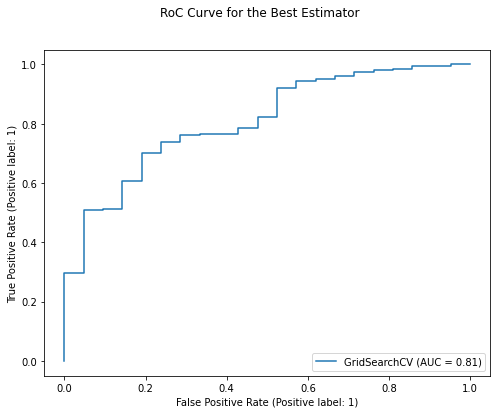

In [25]:
# Plotting the RoC curve and calculating AUC
fig = plt.figure(figsize=[8,6])
plot_roc_curve(grid_search, X_test, y_test, ax=plt.gca())
fig.suptitle('RoC Curve for the Best Estimator')
plt.show()

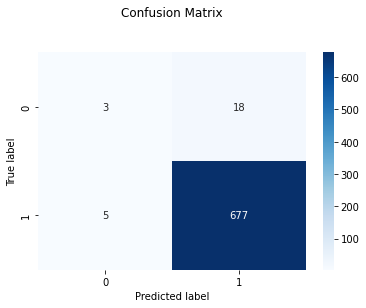

In [27]:
# calculate confusion_matrix
y_pred = grid_search.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

# visualise the confusion_matrix
ax = sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
plt.show()

In [40]:
# Let us now obtain the column names of the one-hot encoded dataset
categorical_columns = grid_search.best_estimator_.named_steps['preprocessor'].transformers_[2][1].named_steps['onehotenc'].get_feature_names_out(categorical_features)
all_columns = numeric_features + categorical_columns.tolist()

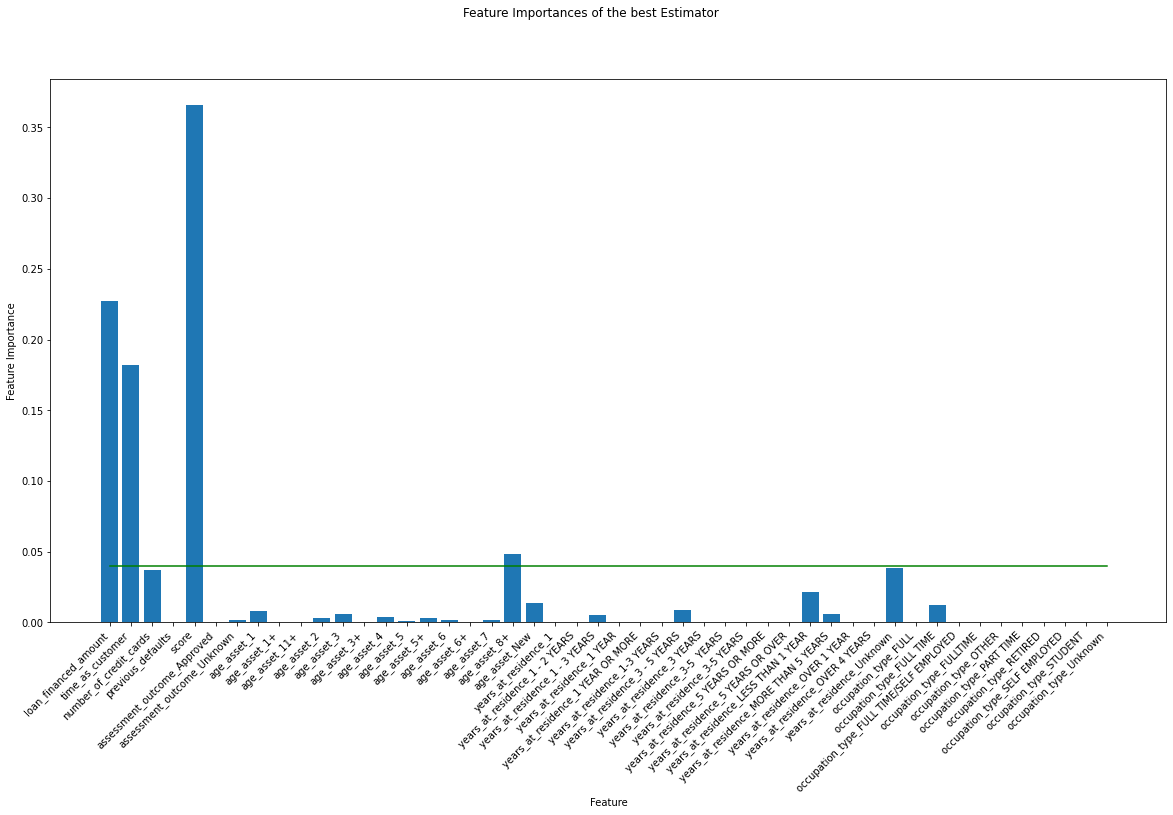

In [44]:
# calculate and visualise feature importances. I am drawing a horizontal line at feature importance = 0.04
importances = grid_search.best_estimator_.named_steps['classifier'].feature_importances_
feature_importances_fig = plt.figure(figsize=[20,10])
plt.bar(all_columns, importances)
plt.plot(all_columns, len(importances)*[0.04], color='green')
plt.xticks(rotation=45, ha='right')
feature_importances_fig.suptitle('Feature Importances of the best Estimator')
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.show()

Looking at the feature importance it can be seen that the 'score', 'loan_financed_amount', 'time_as_customer', 'age_asset', 'years_at_residence' and 'number_of_credit_cards' are the most prominent features in predicting the loan_performance.


### 8). Train the Best Model on Complete Training DataSet

By default, refit of GridSearchCV is true, so this is already done for me

### 9). Save the trained model as a pickle

In [139]:
pickle_file_name = 'loan_performance_predictor.sav'
joblib.dump(grid_search.best_estimator_, pickle_file_name)

loan_performance_predictor = joblib.load(pickle_file_name)

### 10). Further Steps

#### Deploying the Model-as-a-Service
Depending on the business scenario, the chosen model/ pipeline can be deployed as a stand-alone MaaS, Real-time MaaS or an Immersive MaaS.

#### User Acceptance Testing
If I had access to more data or a larger dataset, I would keep a fraction on most recent data to validate the model against the recent data. This would confirm whether the classifier built on historical data is working accuratly for the recent data as well.
If Illion has the 'loan_performance' labels for the client data set (entries with missing target), the model's performance can be validated using the above predictions and the Accuracy score.

#### Model Monitoring
Depending on the business scenario, the model can be re-validated with most recent data, or retrained with a larger amount of data to ensure that it stays upto date with the variations of the independent variables

### (11). Improvements

In business scenarios, the model chosen is not necessarily the most complex and accurate model. Oftentimes the model selection depends on the complexity and maintainability of a model. With the insights gained in above step (7) feature importances evaluation, one can build a simplified model to perform the same task.

Based on the limit set on the feature importances (>0.04), credit score, loan finance amount, time as a customer, and age asset can be considered as the features with the most decisive power. This limit can be set after careful deliberation.